# `ULO`

### theoretical behaviour

In [66]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = "retina"
import warnings
warnings.filterwarnings('ignore')
import random 
import seaborn as sns
sns.set_theme()
sns.set_style('whitegrid')
sns.set_palette("pastel")
import networkx as nx
import cvxpy as cp
import pandas as pd
import time

### utils

In [67]:
## source: https://ipython.org/ipython-doc/3/parallel/dag_dependencies.html

def random_dag(nodes, edges):
    """Generates a random Directed Acyclic Graph (DAG) with a given number of nodes and edges (BRUTE-FORCE)"""
    G = nx.DiGraph()
    for i in range(nodes):
        G.add_node(i)
    while edges > 0:
        a = np.random.randint(0,nodes-1)
        b=a
        while b==a:
            b = np.random.randint(0,nodes-1)
        G.add_edge(a,b)
        if nx.is_directed_acyclic_graph(G):
            edges -= 1
        else:
            # we closed a loop!
            G.remove_edge(a,b)
    G.remove_edges_from(nx.selfloop_edges(G))
    return G

In [68]:
def nu_assignment(graph,slacks_ref,verb=True):
    """Best assigns values to each node respecting suggested hierarchy"""
    threshold = 1e-7
    max_val = 10
    
    # retrieve list of edges
    l_edges = list(graph.edges) # tuples sorted w.r.t. first entries
    assert len(l_edges)==len(slacks_ref), 'there should be as many suggested exp. gaps than number of edges in graph'

    # cvx init. phase
    values_nodes_cvx = cp.Variable(len(graph.nodes))
    values_F_cvx = cp.Variable(len(graph.nodes))
    obj_cvx,cstr_cvx = cp.sum(values_nodes_cvx),[values_nodes_cvx<=max_val,values_nodes_cvx-values_F_cvx>=0]
    for edge,slack in zip(l_edges,slacks_ref):
        cstr_cvx.append(values_F_cvx[edge[0]]>=values_nodes_cvx[edge[1]]+threshold)
        cstr_cvx.append(values_nodes_cvx[edge[0]]>=values_nodes_cvx[edge[1]]+slack)
        
    sinks = [node for node in graph.nodes if graph.out_degree(node) == 0]
    cstr_cvx.append(values_F_cvx[sinks]-values_nodes_cvx[sinks]>=0)
    
    # solve time
    prob_cvx = cp.Problem(cp.Maximize(obj_cvx),cstr_cvx)
    prob_cvx.solve(solver=cp.MOSEK,verbose=verb)
    
    # readjust to favor different values and standardize minimum
    buf = values_nodes_cvx.value
    id_max = np.where(buf>=max_val-1e-2)[0]
    buf[id_max] += np.random.uniform(0,np.mean(slacks_ref),len(id_max))
    buf2 = values_F_cvx.value
    readjust = np.intersect1d(id_max,sinks)
    buf2[readjust] = buf[readjust]
    min_val = min(buf)

    return buf-min_val+1,buf2-min_val+1

In [69]:
def C_sampling(n,m,gamma,upsilon):
    """Creates C(i) sets according to the model"""
    Cs = []
    union = np.array([])
    weights = np.arange(1,m+1)**float(upsilon)
    weights /= sum(weights)
    possibilities = np.arange(m)
    for i in range(n):
        active_i = np.random.choice(possibilities, size=int(gamma*m), replace=False, p=weights)
        Cs.append(active_i.copy())
        union = np.unique(np.concatenate((union,active_i)))
    return Cs,union

In [70]:
def simulation(lamb,omega,n,m,gamma,upsilon,theta,kappa,\
               bar_theta,pi1=1,pi2=1,epsilon_rel=5e-2,epsilon_abs=1e-3,num_trajectories=1,local_seed=0,\
               verboser=False,full_storage=False,total_shut_verboser=False):
    
    np.random.seed(local_seed)
    
    ## pieces' values & structure 
    raw_expected_num_edges = int(kappa*n*(n-1)/2)
    g = random_dag(n,raw_expected_num_edges)
    sinks = [node for node in g.nodes if g.out_degree(node) == 0]
    n_local_min = len(sinks)
    longest_path = nx.dag_longest_path_length(g)
    slacks_ref = np.random.exponential(theta,size=len(list(g.edges)))
    val_nodes,val_Fs = nu_assignment(g,slacks_ref,verb=False)
    CSTs = np.random.exponential(bar_theta,size=n) # gaps per piece for fully constrained problem vs. unconstrained
    F_star = min(val_nodes) # should be 1 but still works if not :)
    
    ## active constraints at critical points
    Cs,union = C_sampling(n,m,gamma,upsilon)
    size_Cs = np.array([len(C_i) for C_i in Cs])
    
    if total_shut_verboser==False:
        print('longest-path: '+str(longest_path))
        print('number of local_min: '+str(n_local_min))
        print('expected min. i^* = '+str(np.argmin(val_nodes)))
        print('len bar C = '+str(len(union)))
        print(' ')
    
    ## LOWER-BOUND model => @rework for more efficiency
    lbs = lambda S: val_nodes-(np.minimum((1-np.array([len(np.intersect1d(C_i,S)) for C_i in Cs])/(size_Cs))**(pi1),(1-len(S)/m)**(pi2))*CSTs)
    
    ## workload function
    oracle_cost = lambda sigma: (lamb+sigma**omega)/(n_test*(lamb+m_test**omega))
    works = []
    bounds = []
    half_HAT = []
    
    pieces = np.arange(n)
    np.random.shuffle(pieces)
    
    for traj in range(int(num_trajectories)):
        
        # init simulation 
        cumulative_work = 0
        UB_traj = []
        LB_traj = []
        online_work_traj,hh = [],np.inf
        F_hat,F_check = np.inf,-np.inf
        i_hat = pieces[traj]
        breaker = False
        
        H,S = [],[]
        
        full_sets_inc,k = 0,0
        
        if verboser:
            print(' ')
            print(' -> START current trajectory ID # '+str(traj+1)+' <- ')
            print(' ')
        
        while breaker==False:
            
            current_work_iteration = 0
            
            # (a) phase
            V,R = [i_hat],np.inf
            while len(V)>0:
                i_bar = np.random.choice(V)
                H.append(i_bar)
                current_work_iteration += oracle_cost(m)
                if verboser:
                    print('i (during phase (a)) = '+str(i_bar))
                if val_nodes[i_bar]>=R:
                    V = np.setdiff1d(V,[i_bar])
                else:
                    R = val_Fs[i_bar]
                    raw_outlinks = list(g.out_edges(i_bar))
                    V = []
                    for ol in raw_outlinks:
                        V.append(ol[1])
                    V = np.setdiff1d(V,H)
            
            F_hat = min(F_hat,val_Fs[i_bar])
            
            if full_storage:
                UB_traj.append(F_hat)
                LB_traj.append(F_check)
                online_work_traj.append(cumulative_work+current_work_iteration)

            if verboser:
                print('i (end phase (a)) = '+str(i_bar))
                    
            dS = Cs[i_bar]
                
            #-> intermediate test 
            breaker = F_hat-F_check<=max(epsilon_abs,min(1,abs(F_hat)*epsilon_rel))
            
            # (b) phase 
            S += list(dS)
            S = list(np.unique(S))
            selectable = np.setdiff1d(np.arange(n),H)
            lower_bounds = lbs(S)[selectable]
            current_work_iteration += len(selectable)*oracle_cost(len(S)) # shift because nu values of somes pieces are known due to added constraints
            LB = min(lower_bounds)
            i_hat = selectable[np.random.choice(np.where(lower_bounds<=LB+1e-6)[0])]
            
            if verboser:
                print('i (end phase (b)) = '+str(i_hat))
                
            if min(lower_bounds)>=F_hat:
                F_check = F_hat # breaker will be True 
            else:
                F_check = max(F_check,LB)

            if full_storage:
                UB_traj.append(F_hat)
                LB_traj.append(F_check)
                online_work_traj.append(cumulative_work+current_work_iteration)

            #-> intermediate test II
            breaker = F_hat-F_check<=max(epsilon_abs,min(1,abs(F_hat)*epsilon_rel))

            ### storing phase ### 
            cumulative_work += current_work_iteration
            
            if cumulative_work<=1/2:
                hh = F_hat
            
            if verboser:
                print('after iteration k = '+str(k)+' | amount of work: '+str(current_work_iteration)[:6]+' | |S|/m = '+str(len(S)/m))
                print('gap: '+str(F_hat-F_check)+' | guarantee : '+str(max(epsilon_abs,min(1,abs(F_hat)*epsilon_rel))))
                
            k += 1
        
        if verboser:
            print(' ')
            print(' -> END current trajectory ID # '+str(traj+1)+' <- ')
            print(' ')
            print(' total relative work: '+str(cumulative_work))
            print(' ')
        works.append([k,cumulative_work])
        if full_storage:
            bounds.append(np.array([UB_traj.copy(),LB_traj.copy(),online_work_traj.copy()]))
        half_HAT.append(hh)
        
        if traj%int(1+num_trajectories/3)==0 and total_shut_verboser==False:
            print('traj complete #'+str(traj+1))
    
    return half_HAT,np.array(works),bounds,len(union),n_local_min,longest_path

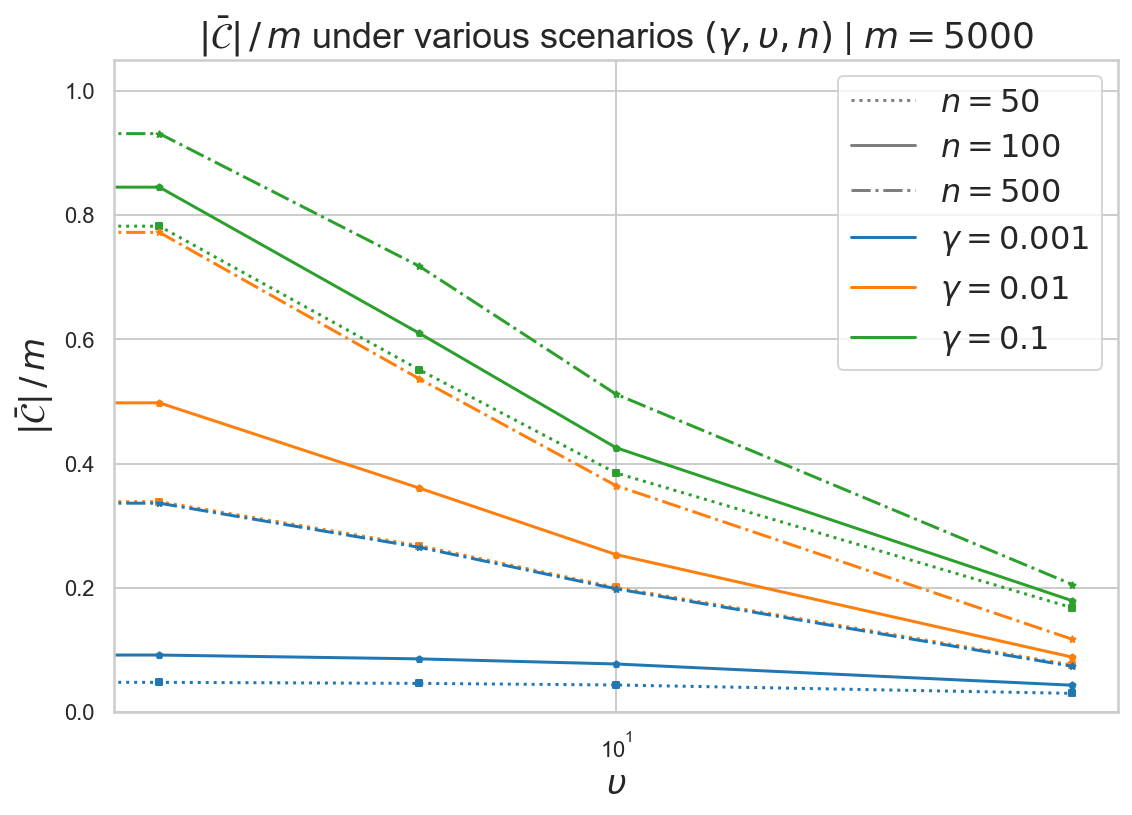

In [71]:
import matplotlib.colors as mcolors

mycolors = list(mcolors.TABLEAU_COLORS)
mystyles = [':','-','-.','--']
mymarkers  = ['s','p','*','d','P']

m_plot = int(5e3)
reps = int(1e2)
gamma_plot = [1/1000,1/100,1/10]
upsilon_plot = [0,2,5,10,50]
n_plot = [int(m_plot/100),int(m_plot/50),int(m_plot/10)]


try:

    store_mat = np.load('mat_C_bar.npy')

except:
    
    print('must compute...')
    print(' ')
    store_mat = np.zeros((len(n_plot),len(gamma_plot),len(upsilon_plot)))
    for istyle,n in enumerate(n_plot):
        print('go for n => '+str(n))
        print(' ')
        for il,gamma in enumerate(gamma_plot):
            print('go for gamma => '+str(gamma))
            print(' ')
            for im,ups in enumerate(upsilon_plot):
                buf = 0
                for rep in range(reps):
                    _,union_test = C_sampling(n,m_plot,gamma,ups)
                    buf = (rep*buf+len(union_test))/(rep+1)
                print('done with upsilon = '+str(ups))
                buf = buf/m_plot
                store_mat[istyle,il,im] = buf
            print(' ')
    np.save('mat_C_bar.npy', store_mat)
    
list_n = []
list_upsilon = []
list_gamma = []
list_values = []

plt.figure(figsize=(9,6))
plt.grid()
plt.xlabel('$\\upsilon$',fontsize=17)
plt.ylabel('$|\\bar{\\mathcal{C}}| \,/\, m$',fontsize=17)
plt.ylim([0,1.05])
plt.xscale('log')
for istyle,n in enumerate(n_plot):
    plt.plot([],[],color='tab:grey',label='$n = '+str(n)+'$',linestyle=mystyles[istyle])
for istyle,n in enumerate(n_plot):
    for il,gamma in enumerate(gamma_plot):
        
        local_vals = store_mat[istyle][il]
        list_n += len(local_vals)*[n]
        list_upsilon += upsilon_plot
        list_gamma += len(local_vals)*[gamma]
        list_values += list(local_vals)
        
        if istyle==0:
            plt.plot([],[],color=mycolors[il],label='$\\gamma = '+str(gamma)+'$')
        plt.plot(upsilon_plot,store_mat[istyle][il],color=mycolors[il],linestyle=mystyles[istyle])
        plt.scatter(upsilon_plot,store_mat[istyle][il],color=mycolors[il],marker=mymarkers[istyle],s=10)
plt.title('$|\\bar{\\mathcal{C}}| \,/\, m$ under various scenarios $(\\gamma,\\upsilon,n)$ | $m = '+str(m_plot)+'$',fontsize=18)
plt.legend(fontsize=16)
plt.grid()
plt.savefig('C_bar_sizes.pdf',dpi=500)

In [72]:
df_plot = pd.DataFrame(data={'$\\gamma$':list_gamma,'$\\upsilon$':list_upsilon,'n':list_n,'vals':list_values})

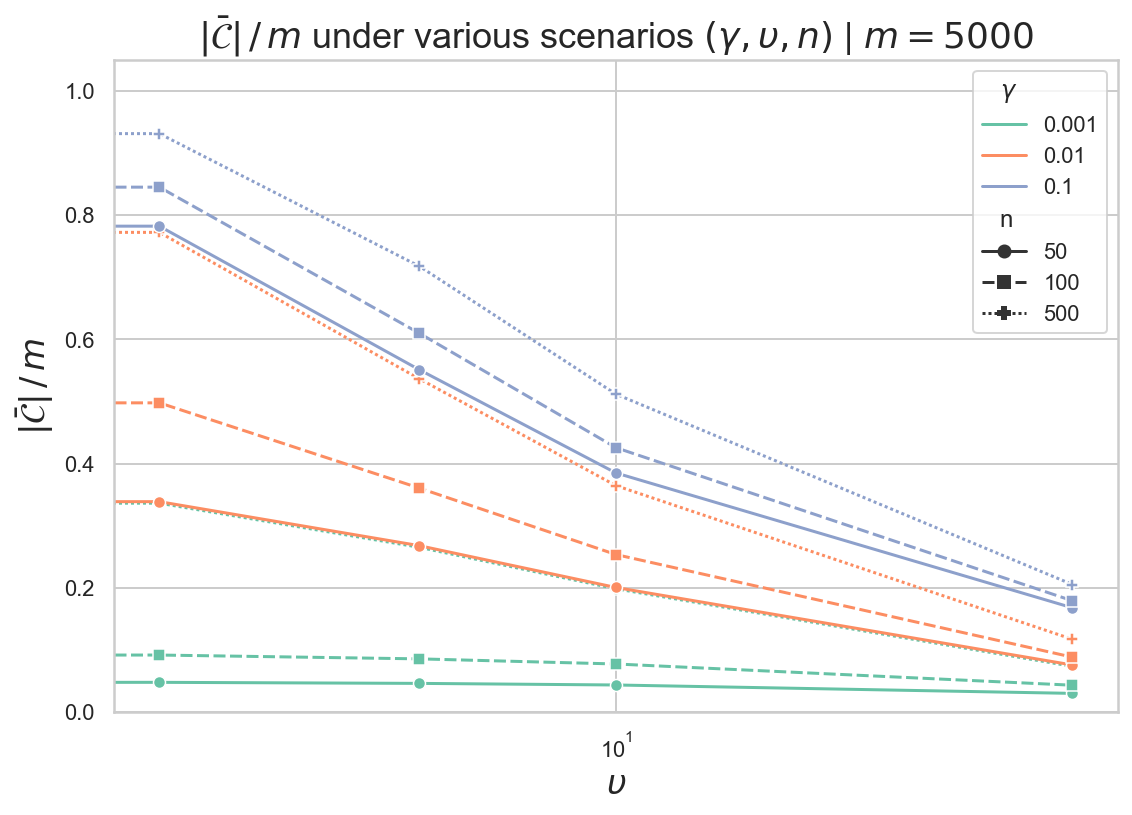

In [83]:
plt.figure(figsize=(9,6))
plt.grid()
plt.xlabel('$\\upsilon$',fontsize=17)
plt.ylabel('$|\\bar{\\mathcal{C}}| \,/\, m$',fontsize=17)
plt.ylim([0,1.05])
plt.xscale('log')
plt.title('$|\\bar{\\mathcal{C}}| \,/\, m$ under various scenarios $(\\gamma,\\upsilon,n)$ | $m = '+str(m_plot)+'$',fontsize=18)
#plt.legend(fontsize=16)
sns.lineplot(x='$\\upsilon$',y='vals',hue='$\\gamma$',style='n',data=df_plot,palette='Set2',markers=['o','s','P'])
plt.grid()
plt.savefig('C_bar_sizes_seaborn.pdf',dpi=500)

In [84]:
### renewed (n and m values)
m_test = int(1e4)
n_test = int(5e2)

### parameters
theta_test = float(10) # expected gap and variance between two "adjacent" pieces
bar_theta_test = theta_test*3 # (see above)
kappa_test = float(1/n_test) # fraction of all possible edges in a complete graph of n nodes
upsilon_test = float(5) # non-uniformity inducing factor ; setting to 0 exhibits the worst-case for ULO
gamma_test = float(1/100) # proportion of active constraints for any given piece
pi1_test,pi2_test = float(1),float(3/2) # non-linearity parameters in the lower-bound model

### cost model
omega_test = float(3/2)
lamb_test = int(((m_test/20)**omega_test)/10)

longest-path: 5
number of local_min: 307
expected min. i^* = 189
len bar C = 5374
 
 
 -> START current trajectory ID # 1 <- 
 
i (during phase (a)) = 227
i (during phase (a)) = 174
i (end phase (a)) = 174
i (end phase (b)) = 118
after iteration k = 0 | amount of work: 0.0061 | |S|/m = 0.01
gap: 212.37705188723106 | guarantee : 1
i (during phase (a)) = 118
i (end phase (a)) = 118
i (end phase (b)) = 406
after iteration k = 1 | amount of work: 0.0058 | |S|/m = 0.0198
gap: 199.79618743639537 | guarantee : 1
i (during phase (a)) = 406
i (during phase (a)) = 275
i (during phase (a)) = 128
i (during phase (a)) = 159
i (end phase (a)) = 159
i (end phase (b)) = 193
after iteration k = 2 | amount of work: 0.0139 | |S|/m = 0.029
gap: 156.0825098198204 | guarantee : 1
i (during phase (a)) = 193
i (end phase (a)) = 193
i (end phase (b)) = 265
after iteration k = 3 | amount of work: 0.0104 | |S|/m = 0.0383
gap: 141.51741173691138 | guarantee : 1
i (during phase (a)) = 265
i (during phase (a)) = 26

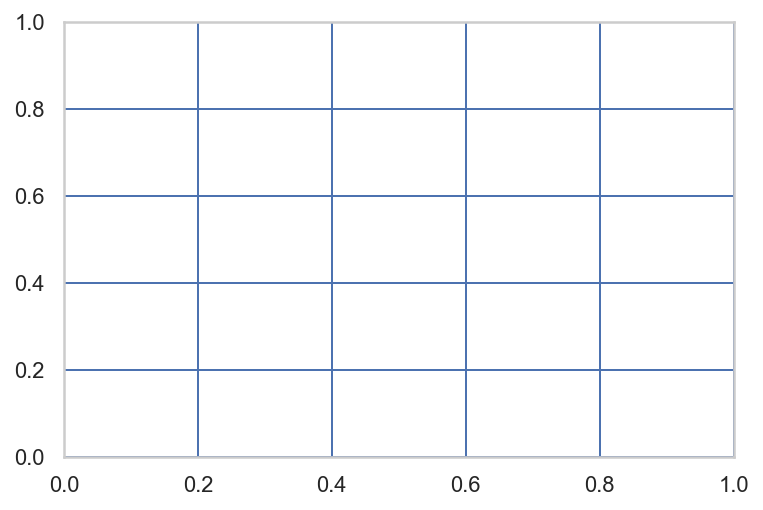

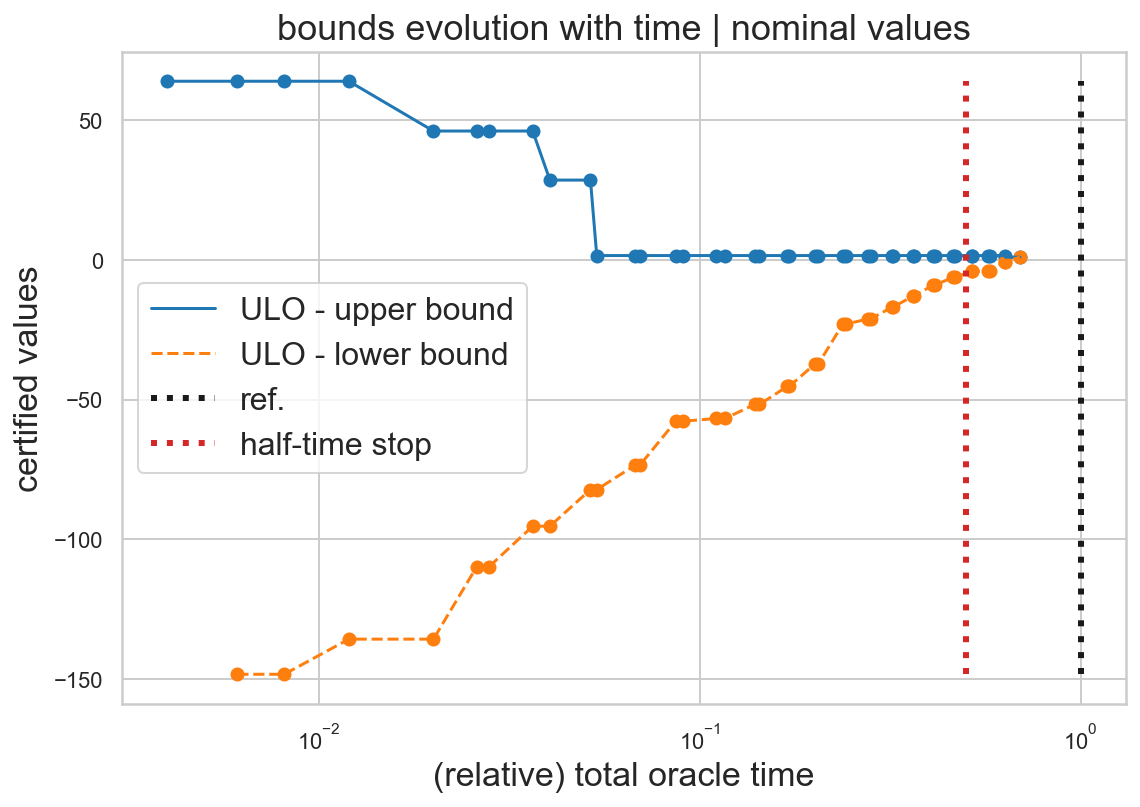

In [85]:
# single shot
half_HAT,works,bounds,C_bar_size,n_local_min,longest_path = simulation(lamb=lamb_test,omega=omega_test,n=n_test,m=m_test,gamma=gamma_test,upsilon=upsilon_test,theta=theta_test,kappa=kappa_test,\
               pi1=pi1_test,pi2=pi2_test,bar_theta=bar_theta_test,epsilon_rel=5e-2,epsilon_abs=1e-3,num_trajectories=int(1),local_seed=10,\
               verboser=True,full_storage=True)
online_w = bounds[0][2]
F_above = bounds[0][0]
F_below = bounds[0][1]
fig, ax = plt.subplots(ncols=1, nrows=1) # These arguments can be omitted for one
                                         # plot, I just include them for clarity


ax.grid(b=True, which='major', color='b', linestyle='-')

plt.figure(figsize=(9,6))
plt.xscale('log')
plt.xlabel('(relative) total oracle time',fontsize=17)
plt.ylabel('certified values',fontsize=17)
plt.title('bounds evolution with time | nominal values',fontsize=18)
plt.scatter(online_w,F_above,color='tab:blue')
plt.scatter(online_w,F_below,color='tab:orange')
plt.plot(online_w,F_above,color='tab:blue',label='ULO - upper bound')
plt.plot(online_w,F_below,color='tab:orange',linestyle='--',label='ULO - lower bound')
plt.plot([1,1],[min(F_below[np.where(F_below>-np.inf)[0]]),max(F_above[np.where(F_above<np.inf)[0]])],color='k',linestyle=':',label='ref.',linewidth=3)
plt.plot([1/2,1/2],[min(F_below[np.where(F_below>-np.inf)[0]]),max(F_above[np.where(F_above<np.inf)[0]])],color='tab:red',linestyle=':',label='half-time stop',linewidth=3)
plt.legend(fontsize=16)
#plt.show()
plt.savefig('single_shot.pdf',dpi=500)

In [ ]:
#-> ranges
theta_range = [1e-1,1,10]
theta_mult_range = [1/2,2,5]
kappa_range = [1/(10*n_test),1/n_test,10/n_test]
upsilon_range = [0,2,5,20]
gamma_range = [1/100,1/10,1/5]
omega_range = [1,3/2,2]
number_seeds = np.arange(100)

In [ ]:
def weighted_sim(local_mult,local_lamb_test,local_omega_test,local_n_test,local_m_test,local_gamma_test,local_upsilon_test,local_theta_test,local_kappa_test,\
               local_pi1_test,local_pi2_test,num_scenarios=int(1e2),ratio_traj=1/2):
    
    # stored info
    MEGA_DIC = {'scenario':[],'half_hat':[],'K':[],'rel_oracle_time':[],'C_bar_size':[],'num_min_loc':[]}
        
    local_bar_theta_test = local_mult*local_theta_test

    #try:
    for scenario in range(num_scenarios):
        if scenario%int(1+num_scenarios/10)==0:
            print('go scenario #'+str(scenario+1))
            total_mute = False
        else:
            total_mute = True
        half_HAT,works,bounds,C_bar_size,n_local_min,longest_path = simulation(lamb=local_lamb_test,omega=local_omega_test,n=local_n_test,m=local_m_test,gamma=local_gamma_test,upsilon=local_upsilon_test,theta=local_theta_test,kappa=local_kappa_test,\
                   pi1=local_pi1_test,pi2=local_pi2_test,bar_theta=local_bar_theta_test,epsilon_rel=5e-2,epsilon_abs=1e-3,num_trajectories=int(1+local_n_test*ratio_traj),local_seed=scenario,\
                   verboser=False,total_shut_verboser=total_mute)
        mean_works = np.mean(works,0)
        MEGA_DIC['scenario'].append(scenario)
        MEGA_DIC['half_hat'].append(np.mean(half_HAT))
        MEGA_DIC['K'].append(mean_works[0])
        MEGA_DIC['rel_oracle_time'].append(mean_works[1])
        MEGA_DIC['C_bar_size'].append(C_bar_size)
        MEGA_DIC['num_min_loc'].append(n_local_min)
        if scenario%int(1+num_scenarios/10)==0:
            print(' ')

    return MEGA_DIC

In [ ]:
"""
HUGE ANALYSIS
"""

DICO = {'scenario':[],'half_hat':[],'K':[],'rel_oracle_time':[],'C_bar_size':[],'num_min_loc':[],\
        'mult':[],'kappa':[],'upsilon':[],'n':[],'m':[]}

time_ref = time.time()

TOTAL_NUM_SIM = len(theta_mult_range)*len(upsilon_range)*len(kappa_range)
num_sim_count = 0


for mult in theta_mult_range:

    print('go for mult = '+str(mult))
    print(' ')

    for upsilon in upsilon_range:

        print('go for upsilon = '+str(upsilon))
        print(' ')

        for kappa in kappa_range: 
            print('go for kappa = '+str(kappa))
            print(' ')
            sub_mega_dic = weighted_sim(local_mult=mult,\
                              local_lamb_test=lamb_test,\
                              local_omega_test=omega_test,\
                              local_n_test=n_test,\
                              local_m_test=m_test,\
                              local_gamma_test=gamma_test,\
                              local_upsilon_test=upsilon,\
                              local_theta_test=theta_test,\
                              local_kappa_test=kappa,\
                              local_pi1_test=pi1_test,local_pi2_test=pi2_test,\
                               num_scenarios = 10)

            num_sim_count += 1 
            size_new_add_on = len(sub_mega_dic['scenario'])
            DICO['mult'] += list(np.ones(size_new_add_on)*mult)
            DICO['kappa'] += list(np.ones(size_new_add_on)*kappa)
            DICO['upsilon'] += list(np.ones(size_new_add_on)*upsilon)
            DICO['n'] += list(np.ones(size_new_add_on)*n_test)
            DICO['m'] += list(np.ones(size_new_add_on)*m_test)
            for key in sub_mega_dic:
                DICO[key] += sub_mega_dic[key].copy()

            total_time = time.time()-time_ref

            print(' ')
            print('ELAPSED TIME: '+str(np.round(total_time,4))+' [s]')
            print('AVERAGE TIME: '+str(np.round(total_time/num_sim_count,4))+' [s]')
            print('EXPECTED TIME: '+str(np.round(total_time*TOTAL_NUM_SIM/num_sim_count,4))+' [s]')
            print(' ')

In [ ]:
lamb_test

In [ ]:
from datetime import datetime
now = datetime.now()
analysis_df = pd.DataFrame(DICO)
tag = str(np.random.randint(10000))+'_'+now.strftime('%m_%d_%Y')
analysis_df.to_csv(tag+'.csv')